In [ ]:
!pip install patchify
!pip install wandb
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.12.0
!pip install -q keras==2.12.0
!pip install keract
!pip install gradio

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import tensorflow as tf
import segmentation_models as sm
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as K
from keras.utils.vis_utils import plot_model
import shutil
import keras
from IPython.display import clear_output
%matplotlib inline
from keras.models import load_model
import keract as ke
import gradio as gr

Segmentation Models: using `tf.keras` framework.


In [ ]:
#computing the IoU between true and predicted labels
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [ ]:
#weights for the loss func
weights = [0.1666, 0.1666]

#creating dice loss func
dice_loss = sm.losses.DiceLoss(class_weights = weights)

#creating focal loss func
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
saved_model = load_model('/content/drive/MyDrive/solar_final/coursework_model.h5', custom_objects=({'dice_loss_plus_1focal_loss': total_loss, 'jaccard_coef': jaccard_coef}))

In [ ]:
image_test = Image.open("/content/drive/MyDrive/solar_final/images to test/img_test_2.jpg")
image_test = image_test.resize((256, 256))
image_test = np.array(image_test)
image_test = np.expand_dims(image_test, 0)

In [ ]:
prediction = saved_model.predict(image_test)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 1s 737ms/step


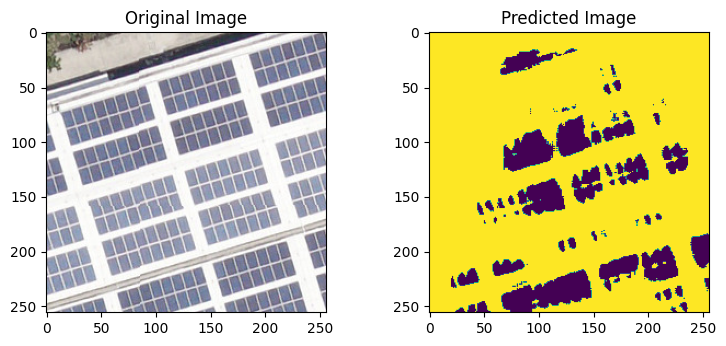

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open("/content/drive/MyDrive/solar_final/images to test/img_test_2.jpg"))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

Creating an interface using Gradio for better visualisation

In [ ]:
def process_input_image(image_source):
  image = np.expand_dims(image_source, 0)

  prediction = saved_model.predict(image_test)
  predicted_image = np.argmax(prediction, axis=3)

  predicted_image = predicted_image[0,:,:]
  predicted_image = predicted_image * 50
  return 'Predicted Masked Image', predicted_image



In [ ]:
 my_app = gr.Blocks()

In [ ]:
with my_app:
  gr.Markdown("Solar Panels")
  with gr.Tabs():
    with gr.TabItem("Select your image"):
      with gr.Row():
        with gr.Column():
            img_source = gr.Image(label="Please select source Image", shape=(256, 256))
            source_image_loader = gr.Button("Load above Image")
        with gr.Column():
            output_label = gr.Label(label="Image Info")
            img_output = gr.Image(label="Image Output")
    source_image_loader.click(
        process_input_image,
        [
            img_source
        ],
        [
            output_label,
            img_output
        ]
    )

    my_app.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 168ms/step
